In [1]:
PATH = "D:/ghd/NLP-Assignments/Assignment2/"
OUTPATH = "D:/ghd/NLP-Assignments/Assignment2/"
# Any results you write to the current directory are saved as output.

In [2]:
Embedding_name="fasttext"
Dataset="NER"
task=''
if Dataset=="NER":
    task="t2"
elif Dataset=="ATE":
    task="t1"

In [3]:
import numpy as np
import pandas as pd
import json
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# !pip install git+https://www.github.com/keras-team/keras-contrib.git

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint,Callback
import matplotlib.pyplot as plt

# !pip install fasttext

import fasttext
import fasttext.util

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from gensim.models import KeyedVectors
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        

Using TensorFlow backend.


In [4]:
# ! mkdir Saved_Models
# ! mkdir Saved_Models/ATE
# ! mkdir Saved_Models/NER
# ! mkdir Graphs

In [5]:
def checking(a):
    print("Hello World",a)

def new_checking(a):
    print("Hello World",a)

def create_train_test_val(file):
    lst_out_text=[]
    lst_out_labels=[]
    for i in file.values():
        sentence = i['text']
        sentence = sentence.lower()
        labels = i['labels']
        lst_out_text.append(sentence)
        lst_out_labels.append(labels)
    return lst_out_text,lst_out_labels    

def TokenCreator(sentences,val,tokenizer=None):
    
    temp_wordlist = None
    tokenizer2=None
    if(tokenizer == None):
        if val==1:
            tokenizer2 = Tokenizer(oov_token="#UK",filters='')
        else:
            tokenizer2=Tokenizer()
        tokenizer2.fit_on_texts(sentences)
        
        temp_wordlist = tokenizer2.texts_to_sequences(sentences)
        return (temp_wordlist,tokenizer2)
    
    else:
        temp_wordlist = tokenizer.texts_to_sequences(sentences)
        return temp_wordlist
    
def find_vocab(dataset):
    lst=[]
    lst.append("#UK")
    for i in dataset:
        for j in i:
            lst.append(j)
    st = set(lst)
    return st

'''
--------------------------------------GRAPHS--------------------------------------
'''

def draw_loss_graph(model,model_name,f1_scores_train,f1_scores_val):
    train_loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = [i+1 for i in range(len(train_loss))]
    train_y = train_loss
    val_y = val_loss
    
    fig, axes = plt.subplots(1,2,figsize = (16,5))
    # plt.subplots(axes = (2,1))
    axes[0].plot(x,train_y, color = 'blue')  
    
    axes[0].plot(x,val_y, color = 'red') 
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    axes[1].plot(x,f1_scores_train, color = 'blue')
    axes[1].plot(x,f1_scores_val, color = 'red')
    axes[1].set_title('F1 Score vs Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')

    axes[0].legend(['Train','Val'])
    axes[1].legend(['Train','Val'])
    
    plt.suptitle(model_name)

    
    plt.savefig(f'{OUTPATH}Graphs/{model_name}.png')
    plt.show()
    

In [6]:
'''
--------------------------------------MODELS--------------------------------------
'''

def save_model(model,model_name, embedding, dataset):
    with open(f'{PATH}Saved_Models/{dataset}/{model_name}_{embedding}.pkl', 'wb') as file:
        pickle.dump(model, file)

def load_model(model_name, embedding, dataset):
    
    with open(f'{OUTPATH}FInal_Models/{dataset}/{task}_{model_name}_{embedding}.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    
    return loaded_model


In [7]:
'''
--------------------------------------CALLBACKS--------------------------------------
'''

class F1ScoreCallback(Callback):

    def __init__(self, val_data, data):
        super(F1ScoreCallback, self).__init__()
        self.val_data = val_data
        self.data=data
        self.val_f1_scores = [] 
        self.train_f1_scores = []

    

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.val_data
        x_data, y_data = self.data
        y_pred_val = self.model.predict(x_val)
        y_pred_train = self.model.predict(x_data)

        def scikitf1(pred,real):

            true_labels_flat = [label for sublist in real for label in sublist]
            predicted_labels_flat = [label for sublist in pred for label in sublist]
            # Compute F1 score
            f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
            return f1
        def get_pred(Y_padded_output):
                # print(Y_padded_output.shape)
                final_output=[]
                for i in range(Y_padded_output.shape[0]):
                    output=[]
                    for j in range(Y_padded_output.shape[1]):
                        max_value=-1
                        maxIndex=-1
                        for k in range(Y_padded_output.shape[2]):
                            if Y_padded_output[i][j][k]>max_value:
                                maxIndex=k
                                max_value=max(max_value,Y_padded_output[i][j][k])
                        output.append(maxIndex)
                    final_output.append(output)
                return final_output

        def get_real(Y_padded_test):
            # print(Y_padded_test.shape)
            final_Y=[]
            for i in range(Y_padded_test.shape[0]):
                output=[]
                for j in range(Y_padded_test.shape[1]):
                    max_value=-1
                    maxIndex=-1
                    for k in range(Y_padded_test.shape[2]):
                        if Y_padded_test[i][j][k]>max_value:
                            maxIndex=k
                            max_value=max(max_value,Y_padded_test[i][j][k])
                    output.append(maxIndex)
                final_Y.append(output)
            return final_Y
        
        # print("here")
        pred_train=get_pred(y_pred_train)
        # print(pred_train)
        real_train=get_real(y_data)
        # print(real_train)

        pred_val=get_pred(y_pred_val)
        real_val=get_real(y_val)

        f1_train = scikitf1(pred_train,real_train)
        f1_val = scikitf1(pred_val,real_val)

        self.val_f1_scores.append(f1_val)
        self.train_f1_scores.append(f1_train)
        print(f'Val F1 Score: {f1_val} - Train F1 Score: {f1_train}')



#---------Prediction Functions----------------------------------------------
def get_pred(Y_padded_output):
    final_output=[]
    for i in range(Y_padded_output.shape[0]):
        output=[]
        for j in range(Y_padded_output.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_output.shape[2]):
                if Y_padded_output[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_output[i][j][k])
            output.append(maxIndex)
        final_output.append(output)
    return final_output

def get_real(Y_padded_test):
    final_Y=[]
    for i in range(Y_padded_test.shape[0]):
        output=[]
        for j in range(Y_padded_test.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_test.shape[2]):
                if Y_padded_test[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_test[i][j][k])
            output.append(maxIndex)
        final_Y.append(output)
    return final_Y

def my_f1(y_true, y_pred):
    
    # predictions = get_pred(y_pred)
    # real = get_real(y_true)

    predictions = y_pred
    real = y_true

    size=len(predictions)

    unique_labels= set()

    for labels in real:
        unique_labels.update(labels)

    for labels in predictions:
        unique_labels.update(labels)

    labels_f1=[]

    for labels in unique_labels:
        tp=0
        fp=0
        fn=0

        for i in range(size):
                    
            tp+=sum((p==labels and r==labels) for p,r in zip(predictions[i],real[i]))
            fp+=sum((p==labels and r!=labels) for p,r in zip(predictions[i],real[i]))
            fn+=sum((p!=labels and r==labels) for p,r in zip(predictions[i],real[i]))

        
        precision = tp/(tp+fp) if tp+fp>0 else 0
        recall = tp/(tp+fn) if tp+fn>0 else 0

        f1=2*((precision*recall)/(precision+recall)) if precision+recall>0 else 0

        labels_f1.append(f1)
        print(f1,unique_labels)
    macro_f1 = sum(labels_f1)/len(unique_labels)
    return macro_f1

def scikitf1(pred,real):

    true_labels_flat = [label for sublist in real for label in sublist]
    predicted_labels_flat = [label for sublist in pred for label in sublist]
    # Compute F1 score
    f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
    return f1

In [8]:
seed_value = 18
np.random.seed(seed_value)


In [9]:
if Embedding_name=="word2vec":
    emb = KeyedVectors.load_word2vec_format(f'{PATH}WordEmbeddings/Word2Vec.bin',binary=True)

if Embedding_name=="glove":
    with open(f'{PATH}WordEmbeddings/glove.840B.300d.pkl', 'rb') as fp:
        emb = pickle.load(fp)
if Embedding_name=="fasttext":
    emb = fasttext.load_model(f'{PATH}WordEmbeddings/cc.en.300.bin')

# Preproc

In [10]:
train = None
test = None
val = None
with open(f"{PATH}Data/processed/{Dataset}_train.json") as f1:
    train = json.load(f1)

with open(f"{PATH}Data/processed/{Dataset}_test.json") as f2:
    test = json.load(f2)

with open(f"{PATH}Data/processed/{Dataset}_val.json") as f3:
    val = json.load(f3)



In [11]:
X_train,Y_train = create_train_test_val(train)
X_test,Y_test = create_train_test_val(test)
X_val,Y_val = create_train_test_val(val)

In [12]:
from keras.preprocessing.text import *

X_train_tokenized, toke = TokenCreator(X_train,1)
X_test_tokenized = TokenCreator(X_test,0,tokenizer = toke)
X_val_tokenized = TokenCreator(X_val,0,tokenizer = toke)

Y_train_tokenized,toke2 = TokenCreator(Y_train,0)
Y_test_tokenized = TokenCreator(Y_test,0,tokenizer = toke2)
Y_val_tokenized = TokenCreator(Y_val,0,tokenizer = toke2)

st1 = find_vocab(X_train_tokenized)
vocab_size  = len(st1) + 1 

max_len=0

for i in X_train_tokenized:
    max_len = max(max_len,len(i))

print(max_len)

X_padded_train = pad_sequences(X_train_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_train = pad_sequences(Y_train_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_test = pad_sequences(X_test_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_test = pad_sequences(Y_test_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_val = pad_sequences(X_val_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_val = pad_sequences(Y_val_tokenized, maxlen=max_len, padding="pre", truncating="post")  

Y_padded_train = to_categorical(Y_padded_train)
Y_padded_test = to_categorical(Y_padded_test)
Y_padded_val = to_categorical(Y_padded_val)

weights = np.zeros((vocab_size, 300))
mapping = toke.word_index 


70


In [13]:

for word, index in mapping.items():
    if word in emb:
        weights[index:] = emb[word]

In [14]:
X_train= X_padded_train
Y_train = Y_padded_train
X_test = X_padded_test
Y_test = Y_padded_test
X_val = X_padded_val
Y_val = Y_padded_val
weights = weights
word_token = toke
tag_token = toke2
Y_shape= Y_padded_train.shape[2]

In [15]:
print(max_len,Y_train.shape)

70 (8019, 70, 28)


# Bilstm+crf

In [16]:
def BiLSTM(weights,vocab_size,max_len,Y_shape):
    if(Dataset=="ATE"):
        if(Embedding_name=="fasttext"):
                input = Input(shape=(max_len,))
                model = Embedding(vocab_size, 300, weights=[weights], input_length=max_len, trainable=False)(input)
                model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5,dropout=0.09,kernel_initializer=k.initializers.he_normal()))(model)
                model = TimeDistributed(Dense(Y_shape, activation="relu"))(model)  # softmax output layer
                crf = CRF(Y_shape)  # CRF layer
                out = crf(model)  # output
                model = Model(input, out)
                adam = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
                model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
                return model
        elif(Embedding_name=="word2vec"):
            input = Input(shape=(max_len,))
            model = Embedding(vocab_size, 300, weights=[weights], input_length=max_len, trainable=False)(input)
            model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5,dropout=0.07,kernel_initializer=k.initializers.he_normal()))(model)
            model = TimeDistributed(Dense(Y_shape, activation="relu"))(model)  # softmax output layer
            crf = CRF(Y_shape)  # CRF layer
            out = crf(model)  # output
            model = Model(input, out)
            adam = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
            model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
            return model
        elif(Embedding_name=="glove"):
            input = Input(shape=(max_len,))
            model = Embedding(vocab_size, 300, weights=[weights], input_length=max_len, trainable=False)(input)
            model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5,dropout=0.2,kernel_initializer=k.initializers.he_normal()))(model)
            model = TimeDistributed(Dense(Y_shape, activation="relu"))(model)  # softmax output layer
            crf = CRF(Y_shape)  # CRF layer
            out = crf(model)  # output
            model = Model(input, out)
            adam = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
            model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
            return model
    elif(Dataset=="NER"):
        if(Embedding_name=="fasttext"):
                input = Input(shape=(max_len,))
                model = Embedding(vocab_size, 300, weights=[weights], input_length=max_len, trainable=False)(input)
                model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5,dropout = 0.2,kernel_initializer=k.initializers.he_normal()))(model)
                model = TimeDistributed(Dense(Y_shape, activation="relu"))(model)  # softmax output layer
                crf = CRF(Y_shape)  # CRF layer
                out = crf(model)  # output
                model = Model(input, out)
                adam = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
                model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
                return model
        elif(Embedding_name=="word2vec"):
                input = Input(shape=(max_len,))
                model = Embedding(vocab_size, 300, weights=[weights], input_length=max_len, trainable=False)(input)
                model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5,dropout=0.1,kernel_initializer=k.initializers.he_normal()))(model)
                model = TimeDistributed(Dense(Y_shape, activation="relu"))(model)  # softmax output layer
                crf = CRF(Y_shape)  # CRF layer
                out = crf(model)  # output
                model = Model(input, out)
                adam = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
                model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
                return model
        elif(Embedding_name=="glove"):
            input = Input(shape=(max_len,))
            model = Embedding(vocab_size, 300, weights=[weights], input_length=max_len, trainable=False)(input)
            model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5,dropout=0.2,kernel_initializer=k.initializers.he_normal()))(model)
            model = TimeDistributed(Dense(Y_shape, activation="relu"))(model)  # softmax output layer
            crf = CRF(Y_shape)  # CRF layer
            out = crf(model)  # output
            model = Model(input, out)
            adam = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
            model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
            return model


In [17]:
model_name="BiLSTM"

n_words=vocab_size
n_tags=Y_train.shape[2]
word_embedding_size = 300


## Testing

In [18]:
# loaded_params=load_model(model_name,Embedding_name,Dataset)
def load_params(model_name, embedding, dataset,task):
    with open(f'{OUTPATH}Final_Models/{dataset}/{task}_{model_name}_{embedding}.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    
    return loaded_model

print(n_words,max_len,n_tags)
loaded_params=load_params(model_name,Embedding_name,Dataset,task)
loaded_model=BiLSTM(weights,n_words,max_len,n_tags)
loaded_model.set_weights(loaded_params)


30220 70 28


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


c:\Users\acer\anaconda3\envs\tf\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
c:\Users\acer\anaconda3\envs\tf\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
accuracy = loaded_model.evaluate(X_test, Y_test, verbose = 1)
print("Accuracy:", accuracy[1])

Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)


949/949 [==============================] - 4s 4ms/step
Accuracy: 0.9616793394088745
Test F1 Score: 0.6432647566619955


In [21]:




Y_pred = loaded_model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)
tag_mapping={v:k for k,v in toke2.word_index.items()}
tag_mapping[0]="PAD"
labels=list(tag_mapping.values())

def convert_sentences_to_values(sentences, word_values):
    result = []
    for sentence in sentences:
        values = []
        for word in sentence:
            values.append(word_values[word])
        result.append(values)
    return result

y_pred_labels = convert_sentences_to_values(pred,tag_mapping)
y_true_labels=convert_sentences_to_values(real,tag_mapping)

print(classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels))


                precision    recall  f1-score   support

             o       0.99      1.00      0.99     32840
   i_precedent       0.54      0.43      0.48       121
   i_provision       0.85      0.75      0.80       178
 i_case_number       0.82      0.72      0.77       221
     i_statute       0.48      0.37      0.42       183
b_other_person       0.50      0.25      0.33         8
         i_org       0.58      0.28      0.38       159
       i_court       0.72      0.49      0.59       275
   b_provision       0.67      0.44      0.53         9
i_other_person       0.74      0.63      0.68       177
        b_date       0.85      0.82      0.84       258
     b_statute       1.00      0.40      0.57         5
         b_org       0.82      0.74      0.78       220
         b_gpe       0.49      0.48      0.49        58
        i_date       0.68      0.74      0.71       344
   b_precedent       0.88      0.74      0.80       326
       b_court       0.86      0.88      0.87  

Text(0.5, 1.0, 'Classwise F1-Score')

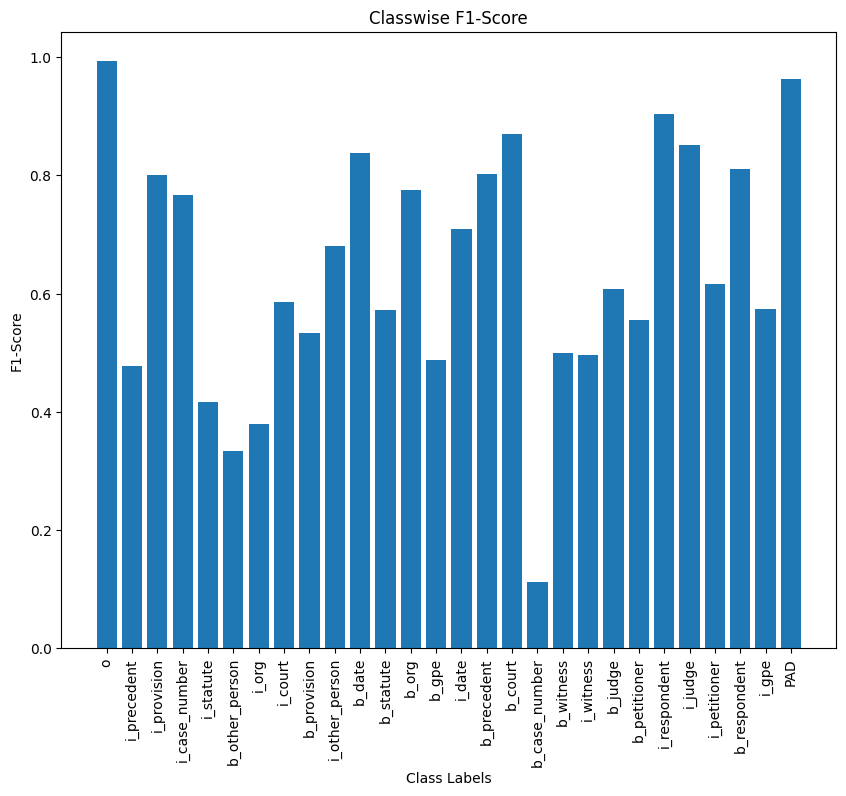

In [22]:

df=pd.DataFrame(classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels,output_dict=True)).T
# all_label_report=classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels,output_dict=True)
x = df.index
x = x[0:-3]
y = [df.loc[i,'f1-score'] for i in x]
plt.figure(figsize=(10,8))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.xlabel('Class Labels')
plt.ylabel('F1-Score')
plt.title('Classwise F1-Score')


In [23]:
# print(labels)
for i in range(len(y_pred_labels)):
    for j in range(len(y_pred_labels[i])):
        # print(y_true_labels[i][j],y_pred_labels[i][j])
        y_true_labels[i][j]=y_true_labels[i][j].replace('i_','b_')
        y_pred_labels[i][j]=y_pred_labels[i][j].replace('i_','b_')

        y_true_labels[i][j]=y_true_labels[i][j].replace('b_','')
        y_pred_labels[i][j]=y_pred_labels[i][j].replace('b_','')
        
labels2=[]
for i in labels:
    if 'i_' not in i:
        labels2.append(i)

for j in range(len(labels2)):
    # labels2[j]=labels2[j].replace('i_','b_')
    labels2[j]=labels2[j].replace('b_','')

# print(y_true_labels)

report = classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels2)
print(report)

              precision    recall  f1-score   support

           o       0.99      1.00      0.99     32840
other_person       0.71      0.71      0.71       465
   provision       0.90      0.77      0.83       504
        date       0.86      0.79      0.82       323
     statute       0.50      0.37      0.42       230
         org       0.67      0.40      0.50        15
         gpe       0.96      0.97      0.96     27699
   precedent       0.63      0.41      0.49       469
       court       0.75      0.56      0.64       473
 case_number       0.69      0.45      0.55        20
     witness       0.91      0.91      0.91      1970
       judge       0.92      0.85      0.88       696
  petitioner       1.00      0.43      0.60        14
  respondent       0.79      0.85      0.82       600
         PAD       0.54      0.60      0.57       112

    accuracy                           0.96     66430
   macro avg       0.79      0.67      0.71     66430
weighted avg       0.96   

Text(0.5, 1.0, 'Classwise F1-Score')

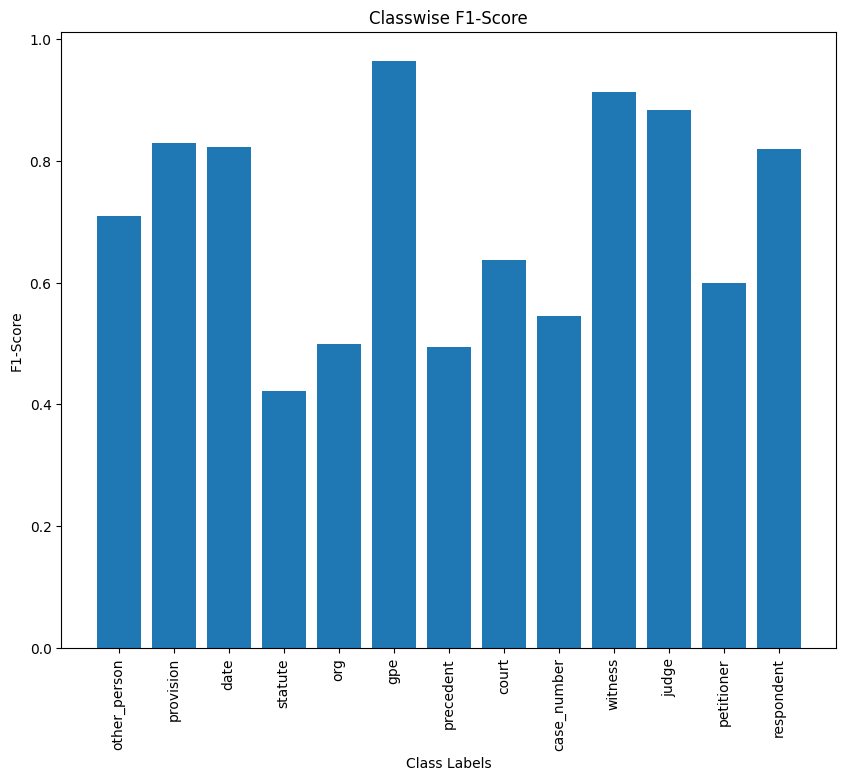

In [24]:
df2=pd.DataFrame(classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels2,output_dict=True)).T
# all_label_report=classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels,output_dict=True)
x = df2.index
x = x[1:-4]
y = [df2.loc[i,'f1-score'] for i in x]
plt.figure(figsize=(10,8))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.xlabel('Class Labels')
plt.ylabel('F1-Score')
plt.title('Classwise F1-Score')
